TODO:
    siflis
    HIV tratamento e controle
    grupos proximos: idade
    taxas de crescimento
    
ideia: baseado em um modelo SIR calcular o valor esperado de numero de contaminados em 2018. 
A diferença entre o valor esperado e o atual seria 

# HIV prevention policy: an econometric evaluation
#### Since 2018,  a medication that prevents hiv indections has been distributed in Brazil.

#### Medication is available to groups historically vunerable to HIV: sex workers, transexual women and homossexual man.

# 3 counterfactuals:
#### Treated and non-treated groups in the same city/region: 
* Outcome variable: new infections after treatment started
* Treated: homossexual group
* Control: heterossexual group

#### The homossexual group in treated and non-treated cities

#### New HIV cases and Hepatites cases in treated group

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

plt.rcParams["figure.figsize"] = [4,3]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
pd.set_option('display.max_columns', 500)
sns.set_style("whitegrid")
plt.style.use('./graph_config.mplstyle')

HET_COLOR = "#00A4CCFF"# "#00A4CCFF"
GAY_COLOR = "#F95700FF" # "#F95700FF"
palette_hetgay = [HET_COLOR,GAY_COLOR]

label_het = "Heterossexual (Control)"
label_gay = "Homossexual (Treated)"
order_hetgay = [label_het,
                label_gay]

SINGLE_COLOR="#b3c6ff"
BINNED_COLOR="#b3c6ff"

filter_years = [2014,2015,2016,2017,2018,2019,2020,2021,2022]

#### useful functions

In [271]:
def melt_groups(df, cols, id_vars=["name","code","year","treated"]):
    # Example: melt_groups(cases, ["hiv_m","hiv_f"])
    return (df.melt(id_vars=id_vars,
               value_vars=cols,
               var_name="group")
          .rename(columns={"variable":"code",
                           "value":"cases"}))

def binned_data(df, var, dict_hist):
    labels = []
    values = []
    for label,interval in dict_hist.items():
        start = interval[0]
        end = interval[1]
        query = f"{var} >= {start} & {var} <= {end}"
        labels.append(label)
        value = df[label] = df.query(query).shape[0]
        values.append(value)

    return pd.DataFrame({"labels":labels, "values":values})

#### outcome variable

## load data, define treatment_intensity and cohorts

In [296]:
cases = pd.read_csv("data/cases_cleaned.csv")
cases = cases.sort_values(['code','year'])
cases = cases.set_index(['code','year','name'])

cities = pd.read_csv("data/cities.csv")
cities = cities.sort_values(['code','year'])
cities = cities.set_index(['code'])#,'year','name'
cities["hiv_het"] = cities["hiv_m"] - cities["hiv_h"]
cities = cities.query("state_code != 42") # missing data for Santa Catarina

regions = pd.read_csv("data/regions.csv")
regions = regions.sort_values(['region_code','year'])
regions = regions.set_index(['region_code'])#,'year','name'
regions["hiv_het"] = regions["hiv_m"] - regions["hiv_h"]
regions = regions.query("state_code != 42") # missing data for Santa Catarina

def compute_treatment_intensity(df):
    df = df.set_index("year")
    baseline_het = df.loc[2018]["hiv_het"].mean()
    baseline_h = df.loc[2018]["hiv_h"].mean()
    baseline_f = df.loc[2018]["hiv_f"].mean()

    df.loc[2019:2022,"diff_to_baseline_het"] = df.loc[2019:2022]["hiv_het"] - baseline_het
    df.loc[2019:2022,"pct_chg_to_baseline_het"] = (df.loc[2019:2022]["hiv_het"] - baseline_het)/baseline_het
    df.loc[2019:2022,"diff_to_baseline_f"] = df.loc[2019:2022]["hiv_f"] - baseline_f
    df.loc[2019:2022,"pct_chg_to_baseline_f"] = (df.loc[2019:2022]["hiv_f"] - baseline_f)/baseline_f

    df.loc[2019:2022,"diff_to_baseline_h"]      = df.loc[2019:2022]["hiv_h"] - baseline_h
    df.loc[2019:2022,"pct_chg_to_baseline_h"]   = (df.loc[2019:2022]["hiv_h"] - baseline_h)/baseline_h
    df.loc[2019:2022,"diff_treat_control"] = df.loc[2019:2022]["pct_chg_to_baseline_h"] - df.loc[2019:2022]["pct_chg_to_baseline_het"]
    df.loc[2019:2022,"diff_treat_control_f"] = df.loc[2019:2022]["pct_chg_to_baseline_h"] - df.loc[2019:2022]["pct_chg_to_baseline_f"]

    df["cummulative_prep"] = 0
    df.loc[2018,"cummulative_prep"] = df.loc[2018,"new_users"]/2

    for y in range(2019,2023):
        df.loc[y,"cummulative_prep"] = (df.loc[y-1,"cummulative_prep"] + 
                                          df.loc[y-1,"new_users"] + 
                                          df.loc[y,"new_users"]/2)

    df["treatment_intensity"] = df["cummulative_prep"]/baseline_h
    df = df.replace(np.inf, None)
    df = df.replace(-np.inf, None)
    return df

index_city_18 = cities.query("year == 2018 & hiv_h > 5").index
cities_outcome = (cities.loc[index_city_18].groupby("code")
                    .apply(compute_treatment_intensity).reset_index())
cities_outcome = cities_outcome.set_index("code")

index_regions_18 = regions.query("year == 2018 & hiv_h > 5").index
regions_outcome = (regions.loc[index_regions_18].groupby("region_code")
                    .apply(compute_treatment_intensity).reset_index())
regions_outcome = regions_outcome.set_index("region_code")

## create thresholds
index_city_18_10 = cities_outcome.query("year == 2018 & hiv_h >= 10").index
index_city_18_15 = cities_outcome.query("year == 2018 & hiv_h >= 15").index
index_city_18_20 = cities_outcome.query("year == 2018 & hiv_h >= 20").index

cities_outcome["level_18_10"] = 0
cities_outcome["level_18_15"] = 0
cities_outcome["level_18_20"] = 0

cities_outcome.loc[index_city_18_10, "level_18_10"] = 1
cities_outcome.loc[index_city_18_15, "level_18_15"] = 1
cities_outcome.loc[index_city_18_20, "level_18_20"] = 1

index_regions_18_10 = regions.query("year == 2018 & hiv_h >= 10").index
index_regions_18_15 = regions.query("year == 2018 & hiv_h >= 15").index
index_regions_18_20 = regions.query("year == 2018 & hiv_h >= 20").index

regions_outcome["level_18_10"] = 0
regions_outcome["level_18_15"] = 0
regions_outcome["level_18_20"] = 0

regions_outcome.loc[index_regions_18_10, "level_18_10"] = 1
regions_outcome.loc[index_regions_18_15, "level_18_15"] = 1
regions_outcome.loc[index_regions_18_20, "level_18_20"] = 1

### DEFINE COHORTS
def query_treatment(df,year,thresh):
    return df.query(f"year == {year} & treatment_intensity >= {thresh}").index.unique()


def define_cohorts(df, thresh):
    treated_in_19 = query_treatment(df,2019,thresh)
    
    df_not_19 = cities_outcome.loc[~df.index.isin(treated_in_19)]
    treated_in_20 = query_treatment(df_not_19,2020,thresh)
    
    df_not_20 = df_not_19.loc[~df_not_19.index.isin(treated_in_20)]
    treated_in_21 = query_treatment(df_not_20,2021,thresh)
    
    df_not_21 = df_not_20.loc[~df_not_20.index.isin(treated_in_21)]
    treated_in_22 = query_treatment(df_not_21,2022,thresh)
    
    df[f"cohort_{thresh}"] = "Never"
    df.loc[treated_in_19, f"cohort_{thresh}"] = "2019"
    df.loc[treated_in_20, f"cohort_{thresh}"] = "2020"
    df.loc[treated_in_21, f"cohort_{thresh}"] = "2021"
    df.loc[treated_in_22, f"cohort_{thresh}"] = "2022"

thresh = 2
define_cohorts(cities_outcome, thresh)

thresh = 4
define_cohorts(cities_outcome, thresh)

(cities_outcome.reset_index()
    [["code","year","state_code","diff_treat_control","treatment_intensity",
      "hiv_het","hiv_h","level_18_10","level_18_15","level_18_20",
         "health_expend","gdpp","cash_transfer_expend","pop20_24",
         "covid_cases"]]
    .to_stata("data/cities_with_outcome.dta"))

(regions_outcome.reset_index()
    [["region_code","year","state_code","diff_treat_control","treatment_intensity",
      "hiv_het","hiv_h","level_18_10","level_18_15","level_18_20",
         "health_expend","gdpp","cash_transfer_expend","pop20_24",
         "covid_cases"]]
    .to_stata("data/regions_with_outcome.dta"))

In [298]:
regions_outcome["covid_cases"].value_counts()

covid_cases
0.0    940
Name: count, dtype: int64

## Parallel trends

In [259]:
df = cities_outcome.query("name == 'Rio de Janeiro' ")#
df[["year","treatment_intensity", "year_treat", "diff_treat_control", "hiv_het", "hiv_h"]]

,year,treatment_intensity,year_treat,diff_treat_control,hiv_het,hiv_h
code,,,,,,
330455,2013,0.000000,2019,NaN,1336,383
330455,2014,0.000000,2019,NaN,1318,356
330455,2015,0.000000,2019,NaN,1313,280
330455,2016,0.000000,2019,NaN,1273,265
330455,2017,0.000000,2019,NaN,1312,195
330455,2018,3.270270,2019,NaN,1166,148
330455,2019,11.716216,2019,-0.259666,1130,105
330455,2020,16.361486,2019,-0.200118,903,85
330455,2021,19.074324,2019,-0.485339,1078,65


In [269]:
#cities_outcome.loc[ ,"treated_2"]
# "hiv_h","treatment_intensity","hiv_het","diff_treat_control", pct_chg_to_baseline_h
test = cities_outcome.query("level_18_20==1").reset_index().melt(id_vars=["code","year","cohort"],
               value_vars=["pct_chg_to_baseline_h"],
               var_name="group")
test["cohort"] = test["cohort"].astype(str)
fig, ax = plt.subplots(figsize=(8,3))
plt.subplot(1,2,1)
sns.lineplot(test.query("year > 2015"),
            x="year", y="value", 
            errorbar=None, hue="cohort_4",
            )

plt.subplot(1,2,2)
test = cities_outcome.query("level_18_20==1").reset_index().melt(id_vars=["code","year","cohort"],
               value_vars=["pct_chg_to_baseline_het"],
               var_name="group")
test["cohort"] = test["cohort"].astype(str)
sns.lineplot(test.query("year > 2015"),
            x="year", y="value", 
            errorbar=None, hue="cohort_4",
            )

cities_outcome.query("level_18_20==1 & year==2020")["cohort"].value_counts()

UndefinedVariableError: name 'level_18_20' is not defined

In [245]:
cities_outcome.query("year == 2018 & level_18_10==1").groupby("cohort")["hiv_h"].mean()

cohort
0       14.722222
2019    95.041667
2020    24.333333
2021    33.400000
2022    25.166667
Name: hiv_h, dtype: float64

In [244]:
cities_outcome.query("cohort == 0").query("year == 2018")["hiv_h"]

code
150080     6
150680    22
210750     6
211120     9
220840     9
230370    15
240325    12
251370     8
260790    21
260960    18
261070    12
280480     7
290320     9
291080    23
310400     9
310670     9
314800     6
315250    11
316720     6
330045     9
330185     6
330340     6
330452    10
330630    19
351060    15
351570     7
351640     9
352050    11
352310     6
352900     9
352940    17
354100    12
354330     9
354580     7
354730     7
355250    12
412625     6
431560    12
431680    12
432300     9
522140     6
522185    11
Name: hiv_h, dtype: int64

In [213]:
cities_outcome.loc[150080][["name","year","treatment_intensity", "year_treat",
                                                       "diff_treat_control", "hiv_het", "hiv_h"]]

,name,year,treatment_intensity,year_treat,diff_treat_control,hiv_het,hiv_h
code,,,,,,,
150080,Ananindeua,2013,0.0,0,NaN,105,17
150080,Ananindeua,2014,0.0,0,NaN,108,10
150080,Ananindeua,2015,0.0,0,NaN,122,12
150080,Ananindeua,2016,0.0,0,NaN,101,16
150080,Ananindeua,2017,0.0,0,NaN,110,14
150080,Ananindeua,2018,0.0,0,NaN,121,6
150080,Ananindeua,2019,0.0,0,0.600551,129,10
150080,Ananindeua,2020,0.0,0,-0.917355,111,0
150080,Ananindeua,2021,0.0,0,1.201102,137,14


In [211]:
cities_outcome.query("year == 2022 & year_treat== 0")[["year","treatment_intensity", "year_treat",
                                                       "diff_treat_control", "hiv_het", "hiv_h"]]

,year,treatment_intensity,year_treat,diff_treat_control,hiv_het,hiv_h
code,,,,,,
150080,2022,0.000000,0,0.095041,49,3
150680,2022,0.818182,0,-0.593366,54,3
210750,2022,0.000000,0,-0.541667,14,2
211120,2022,0.000000,0,-0.611111,25,2
220840,2022,0.666667,0,-0.513889,5,1
230370,2022,0.366667,0,-0.329167,19,1
240325,2022,0.000000,0,-0.131818,21,3
251370,2022,0.500000,0,-0.286765,7,1
260790,2022,0.238095,0,-0.158148,38,4


#### Data description

#### barplot count homossexual x het

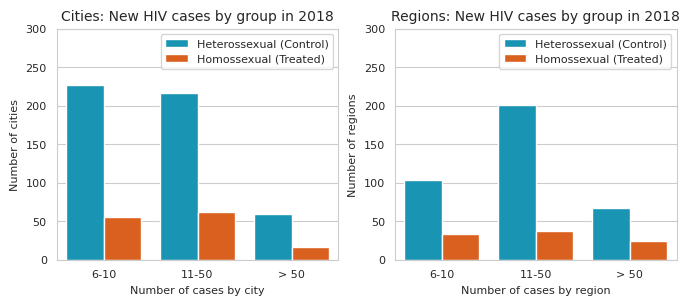

In [37]:
dict_hist = {
    "6-10": [6,10],
    "11-50":[11,50],
    "> 50": [50,100000]
}

het_count_hist = binned_data(cities.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(cities.query("year == 2018"), "hiv_h", dict_hist)

het_count_hist["group"] = label_het
gay_count_hist["group"] = label_gay


hist_count_cities = pd.concat([het_count_hist, gay_count_hist])

##### CITIES

fig, ax = plt.subplots(figsize=(8,3))
plt.subplot(1, 2, 1)
g = sns.barplot(hist_count_cities,
             x="labels", y="values", hue="group",
                palette=palette_hetgay,
                hue_order=order_hetgay)

plt.title("Cities: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of cities")
plt.xlabel("Number of cases by city")
plt.ylim([0,300])


##### REGION

plt.subplot(1, 2, 2)
het_count_hist = binned_data(regions.query("year == 2018"), "hiv_het", dict_hist)
gay_count_hist = binned_data(regions.query("year == 2018"), "hiv_h", dict_hist)

het_count_hist["group"] = label_het
gay_count_hist["group"] = label_gay

hist_count_region = pd.concat([het_count_hist, gay_count_hist])

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(hist_count_region,
             x="labels", y="values", hue="group",
             palette=palette_hetgay,
             hue_order=order_hetgay)

plt.title("Regions: New HIV cases by group in 2018",fontsize=10)
sns.move_legend(g, "upper right", title="",fontsize=8)
plt.ylabel("Number of regions")
plt.xlabel(f"Number of cases by region")

plt.savefig("graphs/new_cases_by_city_region.png", 
               bbox_inches='tight')
plt.ylim([0,300])
plt.show()

#### New users by year

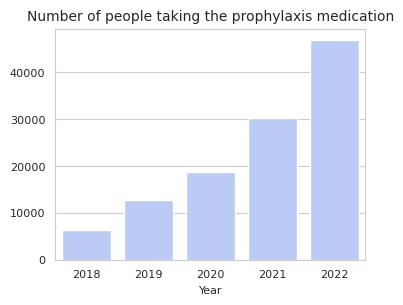

In [7]:
from numpy import count_nonzero
ax = sns.barplot(x="year", y="following",
                 data=cities.query("year in [2018,2019,2020,2021,2022]"),
                 estimator=np.sum, color=SINGLE_COLOR)
plt.title("Number of people taking the prophylaxis medication")
plt.xlabel("Year")
plt.ylabel("")

plt.savefig("graphs/prep_numbers_brazil.png", 
               bbox_inches='tight', dpi=150)
plt.show()

### New HIV cases by year

(0.0, 8000.0)

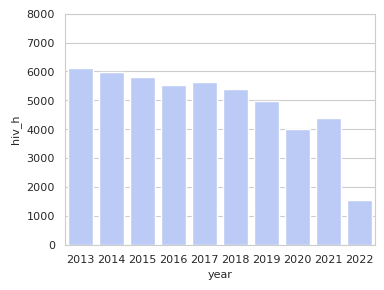

In [8]:
from numpy import count_nonzero
ax = sns.barplot(x="year", y="hiv_h",
                 data=cases.loc[55].reset_index(),
                 color=SINGLE_COLOR)
plt.ylim([0,8000])

### Number of cities by level of treatment by year

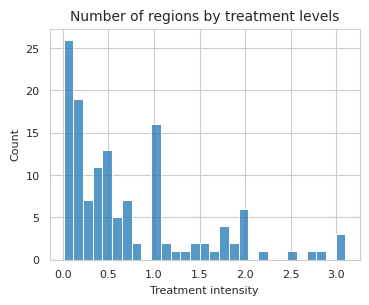

In [8]:
sns.histplot(cities.query("year == 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,3.1,30))
plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

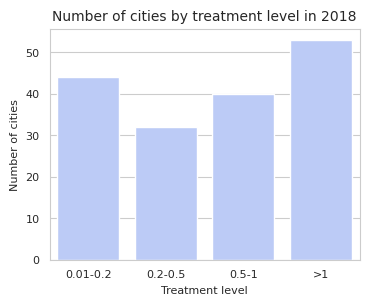

In [9]:
#cases_scatter = cities.query(f"""year == 2018 & pct_following > 0.01 & pct_following < 5 & hiv_h_pct_change < 2 & hiv_h > 5""")
#sns.scatterplot(cases_scatter,
#                x="hiv_h",
#                y="pct_following")

dict_hist = {
    "0.01-0.2": [0.01,0.2],
    "0.2-0.5": [0.2,0.5],
    "0.5-1": [0.5,1],
    ">1": [1,10],
}

cities_by_treat_level = binned_data(cities.query("year == 2018"), "pct_new_users", dict_hist)

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(cities_by_treat_level,
             x="labels", y="values",color=BINNED_COLOR)

plt.title("Number of cities by treatment level in 2018",fontsize=10)
plt.ylabel("Number of cities")
plt.xlabel(f"Treatment level")

plt.savefig("graphs/cities_by_treat_level.png", 
               bbox_inches='tight', )
plt.show()

### Histogram: cities by treatment level

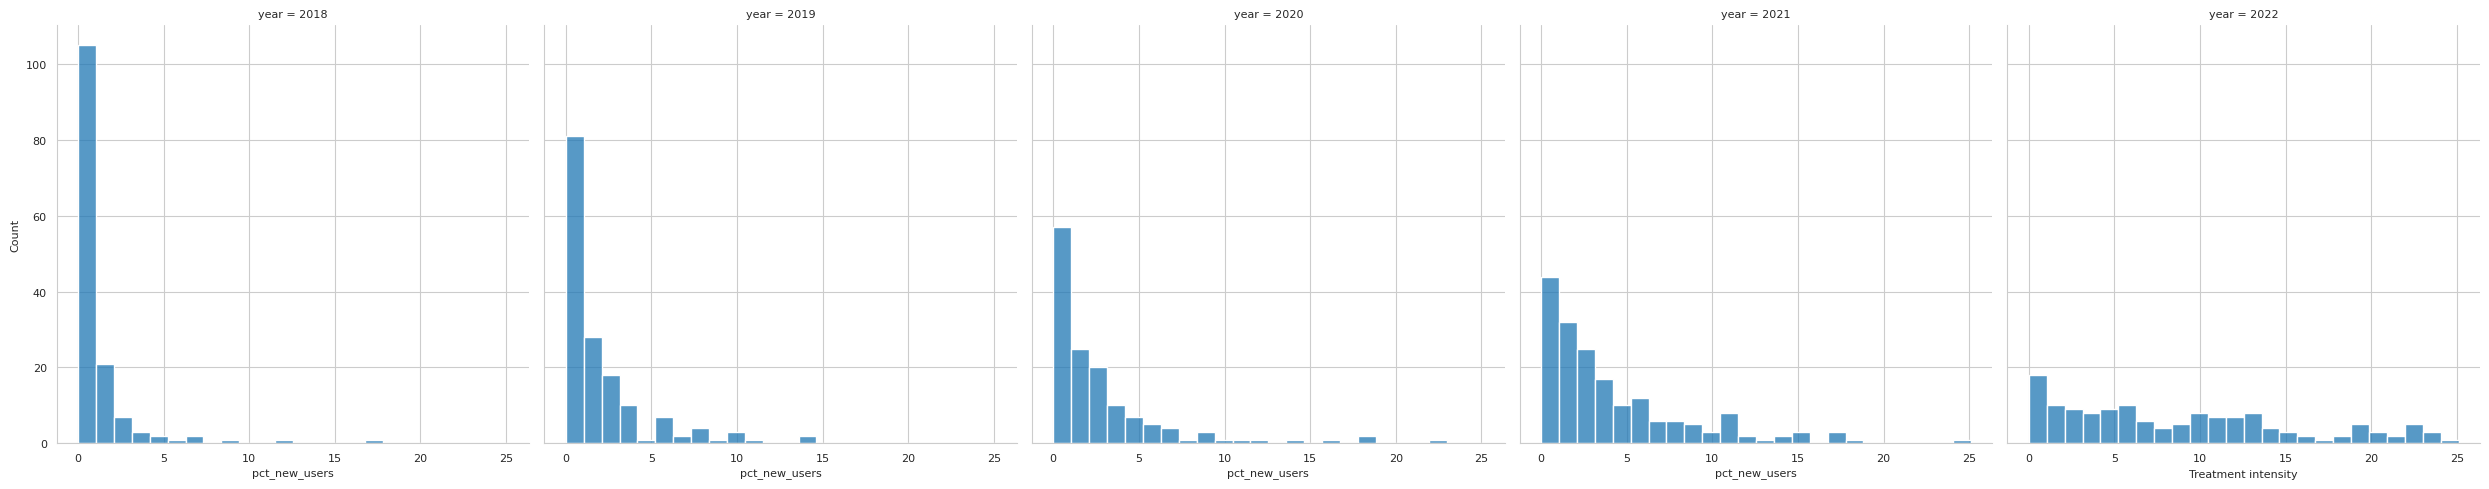

In [552]:
sns.displot(cities.reset_index().query("year >= 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,25.1,25), col="year")
#plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

### Histogram: regions by treatment level

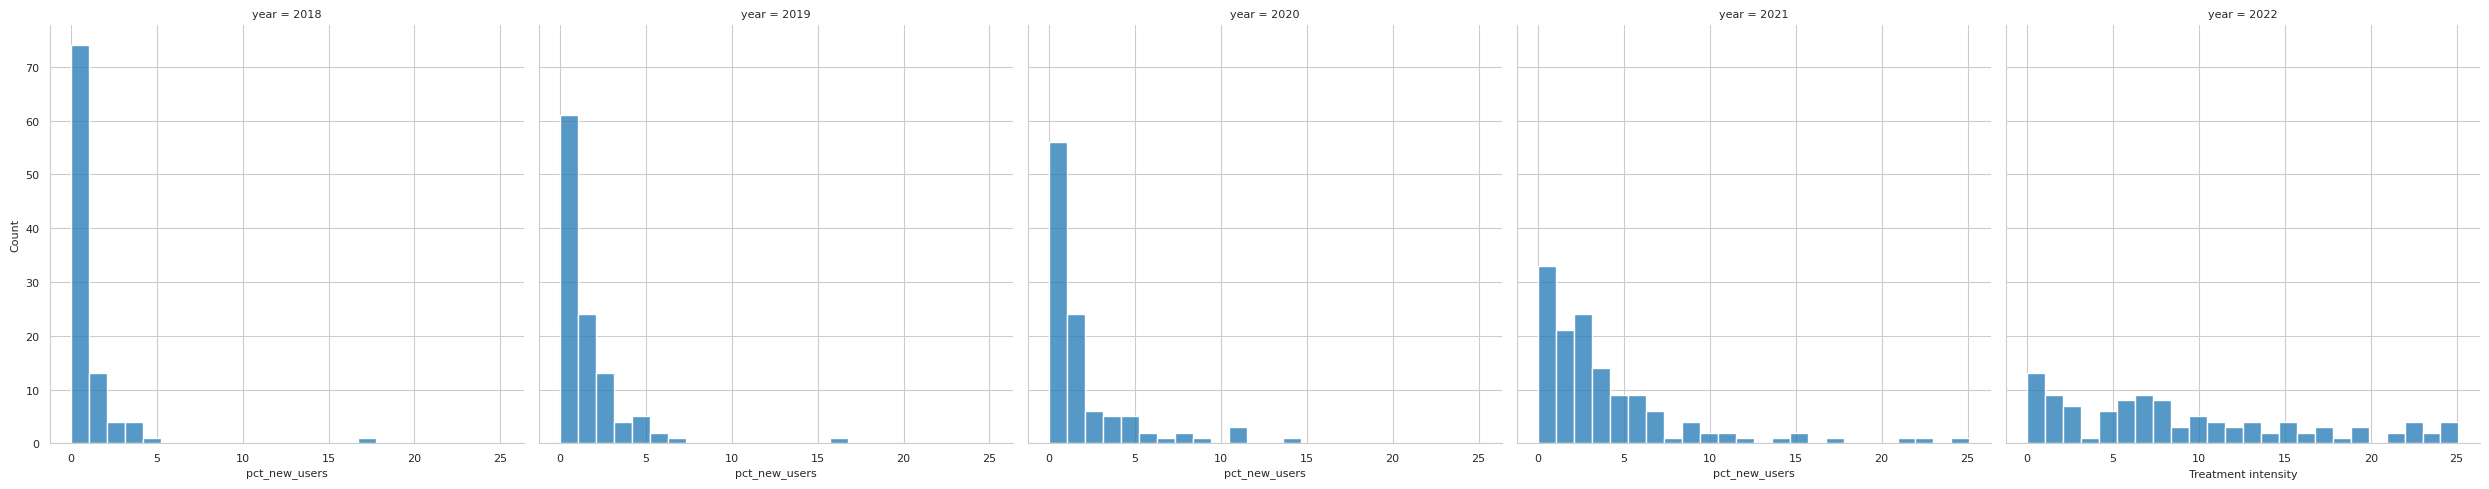

In [513]:
sns.displot(regions.query("year >= 2018"),
             x="pct_new_users",
             bins=np.linspace(0.01,25.1,25), col="year")
#plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

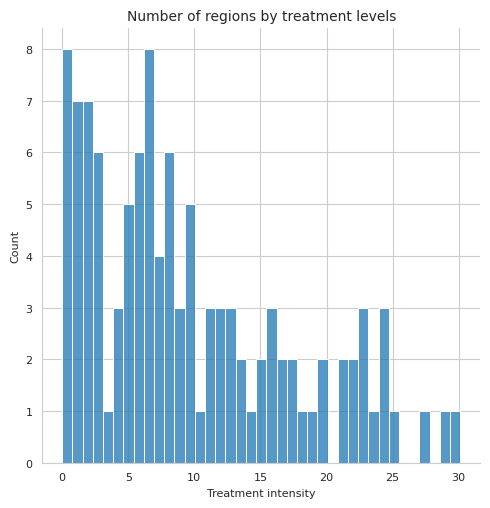

In [77]:
sns.displot(regions.query("year == 2022"),
             x="pct_new_users",
             bins=np.linspace(0.01,30.1,40))
plt.title("Number of regions by treatment levels")
plt.xlabel("Treatment intensity")
plt.show()

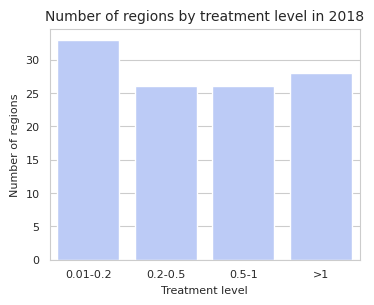

In [11]:
dict_hist = {
    "0.01-0.2": [0.01,0.2],
    "0.2-0.5": [0.2,0.5],
    "0.5-1": [0.5,1],
    ">1": [1,10],
}

regions_by_treat_level = binned_data(regions.query("year == 2018"), "pct_new_users", dict_hist)

#fig, ax = plt.subplots(figsize=(20,10))
g = sns.barplot(regions_by_treat_level,
             x="labels", y="values",color=BINNED_COLOR)

plt.title("Number of regions by treatment level in 2018",fontsize=10)
plt.ylabel("Number of regions")
plt.xlabel(f"Treatment level")

plt.savefig("graphs/cities_by_treat_level.png", 
               bbox_inches='tight', )
plt.show()

### Scatter: City sizes by treatment levels

In [76]:
cities["diff_following_year"] = cities["hiv_het_pct_change_follow_year"] - cities["hiv_h_pct_change_follow_year"]
cities["diff_current_year"] = cities["hiv_het_pct_change"] - cities["hiv_h_pct_change"]

regions["diff_following_year"] = regions["hiv_het_pct_change_follow_year"] - regions["hiv_h_pct_change_follow_year"]
regions["diff_current_year"] = regions["hiv_het_pct_change"] - regions["hiv_h_pct_change"]

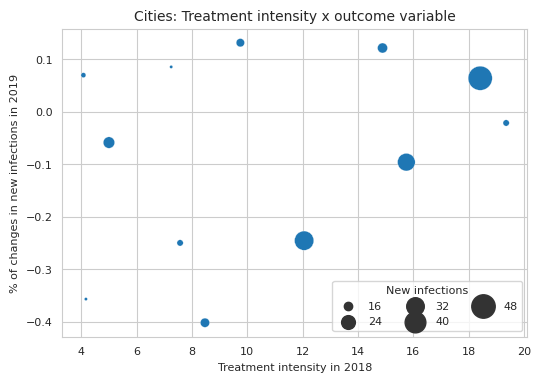

In [63]:
cases_scatter = cities.query(f"""year == 2022 & pct_following > 1 & pct_following < 20 & hiv_h > 5""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="diff_current_year",
                size="hiv_h",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Cities: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("graphs/cities_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

### Scatter: regions by treatment levels

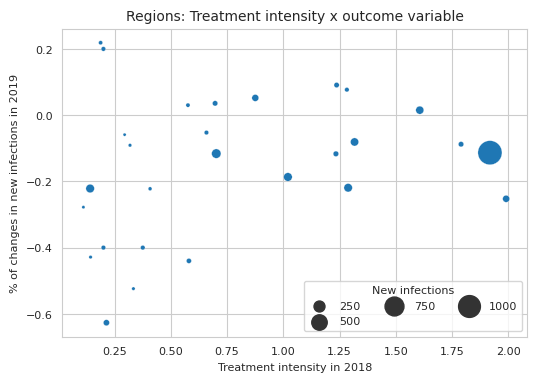

In [436]:
cases_scatter = regions.query(f"""year == 2018 & pct_following > 0.1 & pct_following < 3 & hiv_h_pct_change_follow_year < 0.25 & hiv_h > 15""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="hiv_h_pct_change_follow_year",
                size="hiv_h",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Regions: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("graphs/regions_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

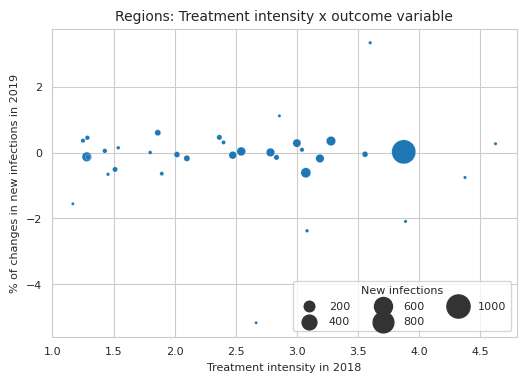

In [434]:
cases_scatter = regions.query(f"""year == 2019 & pct_following > 1 & pct_following < 5 & hiv_h > 5""")

plt.figure(figsize=(6, 4))
g = sns.scatterplot(cases_scatter, x="pct_following", 
                y="diff_current_year",
                size="hiv_h",sizes=(5, 300))
sns.move_legend(g, "lower right", title="New infections",fontsize=8, ncol=3)

plt.title("Regions: Treatment intensity x outcome variable")
plt.xlabel("Treatment intensity in 2018")
plt.ylabel("% of changes in new infections in 2019")

plt.savefig("graphs/regions_treatment_intensity.png", 
               bbox_inches='tight')
plt.show()

## PARALLEL TRENDS

##### define treatment

In [846]:
lower = 2
upper = 12
titles_same_city = [f"Treated cities ({lower} < pct_treat < {upper})",
                    f"Treated cities (pct_treat > {upper})"]

reference_year = 2022
# cities
cities["treated"] = 0

filter18_1 = cities[(cities["year"] == reference_year) & (cities["pct_new_users"].between(lower,upper))].index
cities.loc[filter18_1, "treated"] = 1

filter18_2 = cities[(cities["year"] == reference_year) & (cities["pct_new_users"] > upper)].index
cities.loc[filter18_2, "treated"] = 2

sizes_same_city=[len(cities.query(f"year == {reference_year} & treated == 1 ")),
                 len(cities.query(f"year == {reference_year} & treated == 2 "))]

# regions
titles_same_city = [f"Treated regions ({lower} < pct_treat < {upper})",
                    f"Treated regions (pct_treat > {upper})"]

regions["treated"] = 0
filter18_1 = regions[(regions["year"] == reference_year) & (regions["pct_new_users"].between(lower,upper))].index
regions.loc[filter18_1, "treated"] = 1

filter18_2 = regions[(regions["year"] == reference_year) & (regions["pct_new_users"] > upper)].index
regions.loc[filter18_2, "treated"] = 2

sizes_same_region=[len(regions.query(f"year == {reference_year} & treated == 1 ")),
                 len(regions.query(f"year == {reference_year} & treated == 2 "))]

##### city: homossexual x heterossexual

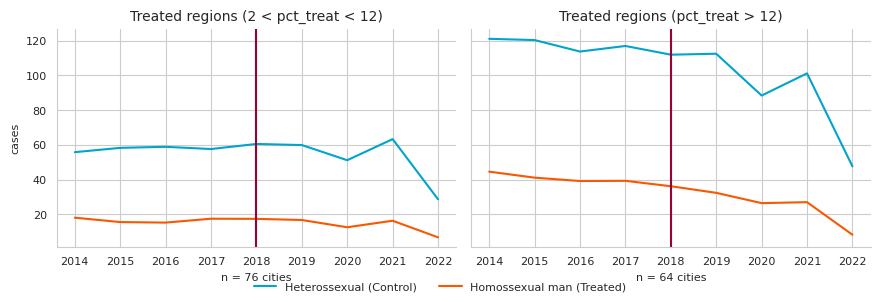

In [847]:
#graph = cities.query(f"hiv_h > 1 & year in {filter_years}")
graph = cities.query(f"treated.isin([1,2]) ")
graph = graph.query(f"year in {filter_years}")

graph["hiv_m_het"] = graph["hiv_m"] - graph["hiv_h"]
graph = melt_groups(graph.reset_index(),
                    ["hiv_m_het","hiv_h"])

graph.loc[graph["group"] == "hiv_m_het","group"]  = label_het
graph.loc[graph["group"] == "hiv_h","group"]  = label_gay

g = sns.relplot(graph.query("treated.isin([1,2])"),
                x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5,
                 palette=palette_hetgay,
                 hue_order=order_hetgay)
plt.xticks(filter_years, fontsize=8)

for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_city):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} cities")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)
plt.savefig("graphs/parallel_trends_treated_cities.png", 
               bbox_inches='tight')
plt.show()

##### region: homossexual x heterossexual

In [673]:
graph = regions.query(f"treated.isin([1,2]) ")
graph = graph.query(f"year in {filter_years}")

graph["hiv_m_het"] = graph["hiv_m"] - graph["hiv_h"]
graph = melt_groups(graph.reset_index(),
                    ["hiv_m_het","hiv_h"],
                   id_vars=["region_name","region_code","treated","year"])

graph.loc[graph["group"] == "hiv_m_het","group"]  = label_het
graph.loc[graph["group"] == "hiv_h","group"]  = label_gay

g = sns.relplot(graph.query("treated.isin([1,2])"),
                 x="year", y="cases", kind="line", estimator=np.mean,
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5,
                 palette=palette_hetgay,
                 hue_order=order_hetgay)

plt.xticks(filter_years, fontsize=8)
for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_region):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} regions")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)

plt.savefig("graphs/parallel_trends_treated_regions.png",
               bbox_inches='tight')
plt.show()

KeyError: 'hiv_m'

### Counterfactual 2: treated and non-treated cities

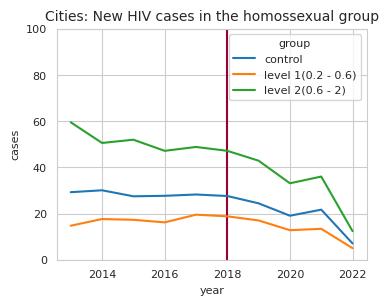

In [706]:
lower = 0.2
middle = 0.6
upper = 2

# cities
cities["treated"] = 0

filter18_1 = cities[(cities["year"] == 2018) & (cities["pct_new_users"].between(lower,middle))].index
cities.loc[filter18_1, "treated"] = 1

filter18_2 = cities[(cities["year"] == 2018) & (cities["pct_new_users"].between(middle,upper))].index
cities.loc[filter18_2, "treated"] = 2

filter_non_treated = cities[(cities["year"] == 2018) & (cities["hiv_h"] > 5) & (cities["treated"] == 0)].index
cities_non_treated = cities.loc[filter_non_treated]

filter_treated_1 = cities[(cities["year"] == 2018) & (cities["hiv_h"] > 5) & (cities["treated"] == 1)].index
cities_treated_1 = cities.loc[filter_treated_1]

filter_treated_2 = cities[(cities["year"] == 2018) & (cities["hiv_h"] > 5) & (cities["treated"] == 2)].index
cities_treated_2 = cities.loc[filter_treated_2]

cities_non_treated["cases"] = cities_non_treated["hiv_h"]
cities_non_treated["group"] = "control"
cities_non_treated = cities_non_treated.set_index('year', append=True)
#cities_non_treated["group"] = #"Homossexual group in control cities"

cities_treated_1["cases"] = cities_treated_1["hiv_h"]
cities_treated_1["group"] = "level 1(0.2 - 0.6)"
cities_treated_1 = cities_treated_1.set_index('year', append=True)
#cities_treated_1["group"] = #"Homossexual group in treated cities (0.2 < % treat < 0.7)"

cities_treated_2["cases"] = cities_treated_2["hiv_h"]
cities_treated_2["group"] = "level 2(0.6 - 2)"
cities_treated_2 = cities_treated_2.set_index('year', append=True)
#cities_treated_2["group"] = "Homossexual group in treated cities (treat > 0.7)"


cities_treated_control = pd.concat([cities_non_treated[["cases","group"]],
           cities_treated_1[["cases","group"]],
           cities_treated_2[["cases","group"]] ]
          ,axis=0).reset_index()

plt.title("")
plt.axvline(x=2018, color='#990033', linestyle='-')
g = sns.lineplot(cities_treated_control,
                x="year", y="cases", 
                errorbar=None, hue="group")
plt.title("Cities: New HIV cases in the homossexual group")
plt.ylim([0,100])
plt.show()

##### gays: treated and non-treated regions

(0.0, 120.0)

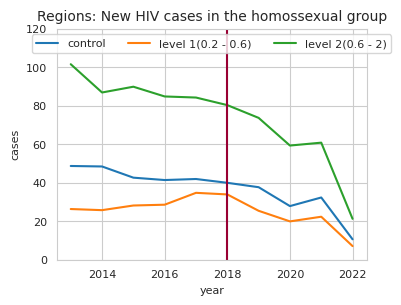

In [707]:
lower = 0.2
middle = 0.6
upper = 2

# cities
regions["treated"] = 0

filter18_1 = regions[(regions["year"] == 2018) & (regions["pct_new_users"].between(lower,middle))].index
regions.loc[filter18_1, "treated"] = 1

filter18_2 = regions[(regions["year"] == 2018) & (regions["pct_new_users"].between(middle,upper))].index
regions.loc[filter18_2, "treated"] = 2

filter_non_treated = regions[(regions["year"] == 2018) & (regions["hiv_h"].between(10,500)) & (regions["treated"] == 0)].index
cities_non_treated = regions.loc[filter_non_treated]

filter_treated_1 = regions[(regions["year"] == 2018) & (regions["hiv_h"].between(10,500)) & (regions["treated"] == 1)].index
cities_treated_1 = regions.loc[filter_treated_1]

filter_treated_2 = regions[(regions["year"] == 2018) & (regions["hiv_h"].between(10,500)) & (regions["treated"] == 2)].index
cities_treated_2 = regions.loc[filter_treated_2]

cities_non_treated["cases"] = cities_non_treated["hiv_h"]
cities_non_treated["group"] = "control"
cities_non_treated = cities_non_treated.set_index('year', append=True)
#cities_non_treated["group"] = #"Homossexual group in control cities"

cities_treated_1["cases"] = cities_treated_1["hiv_h"]
cities_treated_1["group"] = "level 1(0.2 - 0.6)"
cities_treated_1 = cities_treated_1.set_index('year', append=True)
#cities_treated_1["group"] = #"Homossexual group in treated cities (0.2 < % treat < 0.7)"

cities_treated_2["cases"] = cities_treated_2["hiv_h"]
cities_treated_2["group"] = "level 2(0.6 - 2)"
cities_treated_2 = cities_treated_2.set_index('year', append=True)
#cities_treated_2["group"] = "Homossexual group in treated cities (treat > 0.7)"

cities_treated_control = pd.concat([cities_non_treated[["cases","group"]],
           cities_treated_1[["cases","group"]],
           cities_treated_2[["cases","group"]] ]
          ,axis=0).reset_index()

g = sns.lineplot(cities_treated_control,
                x="year", y="cases", 
                errorbar=None, hue="group")
g.axvline(x=2018, color='#990033', linestyle='-')
plt.title("Regions: New HIV cases in the homossexual group")
sns.move_legend(g, "upper center", title="",fontsize=8, ncol=3)
plt.ylim([0,120])

#### COUNTERFACTUAL: HEPATITES

<AxesSubplot: xlabel='treatment_intensity', ylabel='Count'>

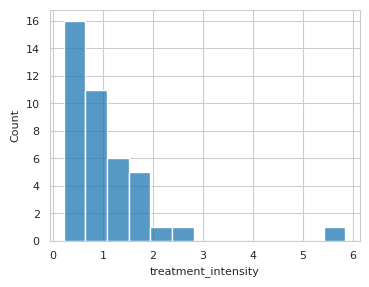

In [456]:
df = cities_reg[cities_reg["treatment_intensity"]!= np.inf].query("year == 2019")
sns.histplot(df.query("treatment_intensity > 0.2 & hiv_h > 10"), x="treatment_intensity")

In [474]:
lower = 0.2
upper = 0.7
titles_same_city = [f"Treated cities ({lower} < pct_treat < {upper})",
                    f"Treated cities (pct_treat > {upper})"]
# cities
df = cities_reg.copy()
df["treated"] = 0

filter19_1 = df[(df["year"] == 2019) & (df["pct_new_users"].between(lower,upper))].index
df.loc[filter18_1, "treated"] = 1

filter19_2 = cities[(df["year"] == 2019) & (df["pct_new_users"] > upper)].index
df.loc[filter18_2, "treated"] = 2

sizes_same_city=[len(df.query("year == 2019 & treated == 1 ")),
                 len(df.query("year == 2019 & treated == 2 "))]

graph = df.query(f"treated.isin([1,2]) ")
filter_years_hep = [2013,2014,2015,2016,2017,2018,2019,2020]
graph = graph.query(f"year in {filter_years_hep}")

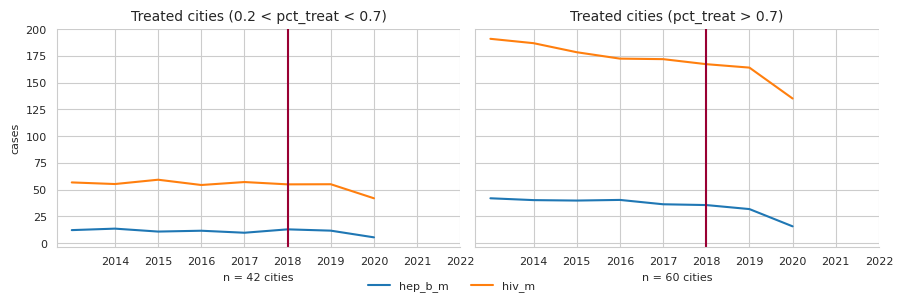

In [475]:

graph = melt_groups(graph.reset_index(),
                    ["hep_b_m","hiv_m"])

#graph.loc[graph["group"] == "hep_b_m","group"]  = "hep_b_m"
#graph.loc[graph["group"] == "hiv_h","group"]  = "hiv_h"

g = sns.relplot(graph.query("treated.isin([1,2])"),
                x="year", y="cases", kind="line",
                 errorbar=None, hue="group", col="treated",
                 height=3, aspect=1.5)
plt.xticks(filter_years, fontsize=8)

for ax,title,size in zip(g.axes.flatten(),titles_same_city,sizes_same_city):
    ax.set_title(title )
    ax.axvline(x=2018, color='#990033', linestyle='-')
    ax.set_xlabel(f"n = {size} cities")

sns.move_legend(g, "lower center", title="",fontsize=8, ncol=2)
#plt.savefig("graphs/parallel_trends_treated_cities.png", 
#               bbox_inches='tight')
plt.show()

## create panel

In [252]:
#def wheighted_sum(values):
#    size = len(values)
#    if size == 1:
#        return values[0] / 2
#
#    summed_values = 0
#    for i,v in enumerate(values[0:(size-1)]):
#        print(i,v,size-i-1)
#        summed_values += v*(size-i)
#
#    return summed_values + (values[size-1] / 2)
#
#assert wheighted_sum([20]) == 10
#assert wheighted_sum([20, 50]) == 45 # 40 + 25
#assert wheighted_sum([20, 50, 200]) == 260 # 60 + 100 + 100

In [496]:
#cases.query("name.str.contains('Rio de J')")

In [497]:
#compute_treatment_intensity(cases.set_index("code").loc[330455])

In [567]:
cities_reg.query("name.str.contains('José do Rio Preto')")[["year","treatment_intensity"]]

,year,treatment_intensity
code,,
354980,2013,0.000000
354980,2014,0.000000
354980,2015,0.000000
354980,2016,0.000000
354980,2017,0.000000
354980,2018,0.000000
354980,2019,1.232143
354980,2020,4.035714
354980,2021,6.000000


In [566]:
cities_reg["cities_reg"] = (cities_reg["treatment_intensity"] > 2).astype(int)
cities_reg.groupby("year")["cities_reg"].mean()

year
2013    0.000000
2014    0.000000
2015    0.000000
2016    0.000000
2017    0.000000
2018    0.000000
2019    0.009351
2020    0.022838
2021    0.032908
2022    0.045675
Name: cities_reg, dtype: float64

In [592]:
(cities_reg.reset_index()
    [["code","year","state_code","diff_treat_control","treatment_intensity",
         "hdi","gdpp","inappr_sanitation",
         "hiv_het","hiv_h"]]
    .to_stata("data/cities_with_outcome.dta"))
#regions_reg["state_code"] = regions_reg.index.astype(str).str.slice(0,2)
(regions_reg.reset_index()
    [["region_code","year","state_code","diff_treat_control","treatment_intensity",
         "hdi","gdpp","inappr_sanitation",
         "hiv_het","hiv_h"]]
    .to_stata("data/regions_with_outcome.dta"))

In [489]:
#cities_reg.loc[330455][["hiv_het",
#    "diff_to_baseline_het",
#    "pct_chg_to_baseline_het",
#    "hiv_h",
#    "diff_to_baseline_h",
#    "pct_chg_to_baseline_h",
#    "pct_chg_to_baseline_f",
#    "cummulative_prep",
#    "treatment_intensity",
#    "diff_treat_control",
#    "diff_treat_control_f"]]

In [842]:
#cities_reg.query("year == 2022 & treatment_intensity > 2 & hiv_h > 5")

In [638]:
#cities_reg.query("year == 2021 & hiv_het > 5 & treatment_intensity < 1 & state_code != 42")[["name","state_code","diff_treat_control"]]

In [843]:
#cities_reg.query("name == 'São Paulo'")

(33, 33)


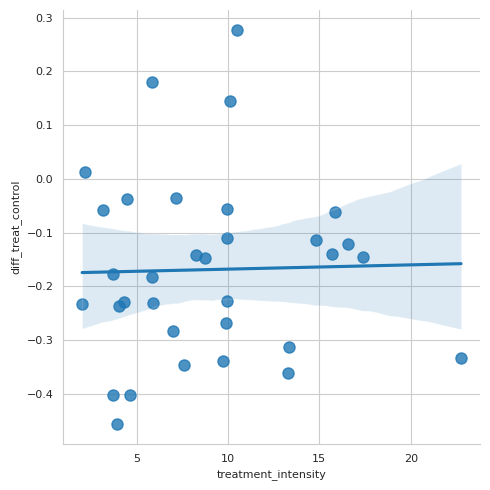

In [745]:
index_regions = regions_reg.query("year == 2018 & hiv_h >= 30").index
plot_df = (regions_reg.loc[index_regions]
                .query("year.between(2022,2022) & treatment_intensity.between(2,30)"))
print(plot_df.shape)
scat = (plot_df
        [["treatment_intensity","diff_treat_control"]])
sns.lmplot(scat, x="treatment_intensity",y="diff_treat_control")#treatment_intensity.between(0,1) & 
plt.show()

In [632]:
regions_reg.loc[110005][["treatment_intensity","diff_treat_control","hiv_het","hiv_h"]]#.query("diff_treat_control > 2")

,treatment_intensity,diff_treat_control,hiv_het,hiv_h
region_code,,,,
110005,0.0,NaN,8,2
110005,0.0,NaN,8,3
110005,0.0,NaN,6,4
110005,0.0,NaN,2,1
110005,0.0,NaN,4,1
110005,0.0,NaN,3,1
110005,0.0,2.000000,3,3
110005,0.5,3.333333,2,4
110005,2.5,3.333333,2,4


# Estimation

### Model 1 (pre-covid): binary treatment version: two-way fixed effects

$\Delta_{i_{t+1}} = \beta treat * post + X_i + \sigma_i + \tau_t + \epsilon_i $

$\Delta_{i_{t+1}}$: variation in the % of cases for city i in year t+1

$ treat $: indicator if in a city i, treatment was above a certain threshold

$X_i$: controls: (city characteristics, health service indicators)

$\sigma_i$: city/region FE

$\tau_t$: year FE

### Model 2 (pre and postcovid): continuous treatment version

# Results: nothing significant



_

# Issues for identification:
#### selection into treatment: bigger cities offer more treatment
#### big confounder: covid



_

# Issues for estimation:
#### small sample
#### continous treatment
#### dynamic effects
#### for binary treatment: establishing the threshold
#### how to properly weight city sizes



_

# Key takeaway:
##### The ammount of treatment was not enough to have an impact in the reduction of cases in the treatment group



_

# Contributions:
#### Dataset for future research
#### This policy was the main innovation in the prevention of HIV in the past decade. This paper is first time it is evaluated as an observational study with
#### If time allows: python package for continuous treatment effect estimation (Callaway/Sant'anna/Goodman-Bacon, Chaisemartin and d'haultfoeuille



_

# Sidenote
#### All results are on github and easily reproducible



_

# TODO:
* WRITE
* Add controls
* Account for old HIV cases
* Think of weighting/matching
* Try the hepatites cases as a counterfactual
* Try continous treatment estimation

In [31]:
y_1 = np.random.normal(0, 1, 1000)
e = np.random.normal(0, 0.1, 1000)
y_2 = y_1 + np.tile(-3,1000) + e #np.linspace(0,-2,1000) + e

d_1 = np.tile(0,1000)
d_2 = np.tile(1,1000) + e #np.linspace(0,20,1000)

y = np.hstack( [y_1,y_2] )
d = np.hstack( [d_1,d_2] )

dic = {"d":d,
       "y":y}
data = pd.DataFrame(dic)
import statsmodels.formula.api as smf
smf.ols('y ~ d', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0057,0.032,-0.177,0.859,-0.068,0.057
d,-2.9221,0.045,-65.357,0.000,-3.010,-2.834


In [32]:
dic = {"d":d_2,
       "y":y_2 - y_1}
data = pd.DataFrame(dic)
smf.ols('y ~ d', data=data).fit().summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-4.0000,1.08e-16,-3.69e+16,0.000,-4.000,-4.000
d,1.0000,1.08e-16,9.29e+15,0.000,1.000,1.000


In [30]:
y_2 - y_1

array([-3.14760831, -2.93005781, -3.06266638, -2.91329868, -3.08457617,
       -2.89525692, -3.06911467, -2.90916835, -3.11185138, -2.80202929,
       -3.00405393, -2.94006634, -2.91838712, -2.91404205, -2.99637908,
       -2.8683791 , -2.84965481, -3.04585683, -3.01363177, -3.12026098,
       -3.13104632, -3.05074987, -2.82661857, -2.94385849, -2.97539148,
       -2.96302869, -2.9027469 , -3.19600002, -3.258073  , -2.93152563,
       -2.96128871, -2.99532604, -3.04078678, -2.97876185, -2.96222205,
       -2.95053978, -2.9171592 , -2.83858478, -2.94874545, -3.00119402,
       -3.01496819, -3.24924742, -2.99878982, -3.00563498, -3.05563444,
       -2.95489516, -2.83387313, -3.05262699, -3.01307655, -2.99958313,
       -3.04358113, -2.92636612, -2.86316789, -3.06547175, -2.98609336,
       -2.83362922, -3.01212067, -2.94825639, -2.90998405, -3.05445166,
       -2.97244574, -2.98352075, -3.08499666, -2.9661392 , -2.87647304,
       -3.11762043, -3.1808044 , -2.90115567, -2.75622609, -3.24

In [ ]:
#def pct_change_2(series):
#    return series.pct_change(2)
#
#outcomes = (cities
#            #.set_index(['code','year','name'])
#    .groupby(["code"])
#    .agg({"hiv_total": "pct_change",
#          "hep_b_total":"pct_change",
#          "hep_b_m":"pct_change",
#          "hep_b_f":"pct_change",
#          "hiv_h":"pct_change",
#          "hiv_het":"pct_change",
#          "hiv_f":"pct_change"}))
#
#outcomes = outcomes.add_suffix('_pct_change')
#cities = pd.concat([cities, outcomes], axis=1).reset_index().set_index("code")
#
#cities["hiv_het_pct_change_follow_year"] = cities.shift(-1)["hiv_het_pct_change"]
#cities["hiv_h_pct_change_follow_year"] = cities.shift(-1)["hiv_h_pct_change"]

#regions = pd.read_csv("data/regions.csv")
#
#regions = regions.set_index(['region_code','year','region_name'])
#outcomes_region = (regions
#            #.set_index(['code','year','name'])
#        .groupby("region_code")
#        .agg({
#             "hiv_total":"pct_change",
#             "hiv_h":"pct_change",
#             "hiv_het":"pct_change",
#             "hiv_bi":"pct_change",
#             "hiv_f":"pct_change",
#             "hep_b_total":"pct_change",
#             "hep_b_m":"pct_change",
#             "hep_b_f":"pct_change",
#             "following":"pct_change",
#             "loss_of_follow":"pct_change",
#             "new_users":"pct_change"
#})
#)
##regions = regions.reset_index().set_index("region_code")
#
#outcomes_region = outcomes_region.add_suffix('_pct_change')
#regions = pd.concat([regions, outcomes_region], axis=1).reset_index().set_index("region_code")
#
#regions["hiv_het_pct_change_follow_year"] = regions.shift(-1)["hiv_het_pct_change"]
#regions["hiv_h_pct_change_follow_year"] = regions.shift(-1)["hiv_h_pct_change"]